# Imports

In [1]:
import autograd.numpy as np
from autograd import grad, elementwise_grad
import autograd.numpy.random as npr
import myOptimizers as optims
import os
import importlib

# Function Definitions

In [2]:
# Weight initialisation
def init_random_params(scale, layer_sizes, rs=npr.RandomState(42)):
    return [(rs.randn(insize, outsize) * scale,   # weight matrix
             rs.randn(outsize) * scale)           # bias vector
            for insize, outsize in zip(layer_sizes[:-1], layer_sizes[1:])]

# Activation function
def tanh(x):
    return (2 / (1.0 + np.exp(-2*x))) - 1
    #return np.log(1+np.exp(x))
    #return np.exp(x)

# Returns the NN output AFTER enforcing the boundary condition. This is the wavefunction (wf).
def psi(nnparams, inputs):
    origInput = inputs
    xTilde = (origInput - x0) / (x1 - x0)
    
    for W, b in nnparams:
        outputs = np.dot(inputs, W) + b
        inputs = tanh(outputs)    
        
    # Enforcing the boundary conditions
    return (1-xTilde)*psi0 + xTilde*psi1 + (1-np.exp(xTilde * (1 - xTilde))) * outputs


dpsi = elementwise_grad(psi, 1) # Function for returning first derivative of wf (not used explicitly)
ddpsi = elementwise_grad(dpsi, 1) # Second derivative of wf. 

In [3]:
PRC1 = 20 # Probability regularisation co-efficient for degree 1 (and -1)
PRC2 = PRC1/(2*2) # Probability regularisation co-efficient for degree 2 (and -2)
PRC3 = PRC2/(2*3) # Probability regularisation co-efficient for degree 3 (and -3)
PRC4 = PRC3/(2*4) # Probability regularisation co-efficient for degree 4 (and -4)

def floatStr (Efloat) :
    Eint = int(np.floor(Efloat))
    if Efloat - Eint == 0 :
        return str(int(np.floor(Efloat)))
    else :
        Estr = str(Efloat)
        return str(int(np.floor(Efloat))) + "p" + Estr[Estr.find('.')+1:]

# Objective function
def objective(params, step):
    nnparams = params['nn']
    E = params['E']        
    
    wf = psi(nnparams,x)    # Wavefunction
    diffeq = -0.5 * ddpsi(nnparams, x)  - E*wf  # Schrodinger equation in functional form
    y2 = wf**2   # Probability density function
    
    # This is a numerical trapezoid integration
    prob = np.sum((y2[1:] + y2[0:-1]) / 2 * (x[1:] - x[0:-1]))
    

    return np.mean(diffeq**2) + (1-prob)**2 + (PRC1/prob + PRC1*prob) + \
        (PRC2/prob**2 + PRC2*prob**2) + (PRC3/prob**3 + PRC3*prob**3) + \
        (PRC4/prob**4 + PRC4*prob**4)


trunc = -1
iterList = []
diffeqList = []
diffeqDiffList = []
probList = []
lossList = []
EList = []
# Helper function for callback. Prints the following -
# 1. Iteration no.
# 2. MSE term
# 3. Probability integral
# 4. Loss
# 5. Eigen-energy 
def objectiveDebug (params, step) :
    nnparams = params['nn']
    E = params['E']   
    
    wf = psi(nnparams,x)    # Wavefunction
    diffeq = -0.5 * ddpsi(nnparams, x)  - E*wf  # Schrodinger equation in functional form
    y2 = wf**2   # Probability density function
    mean = np.mean(diffeq**2)  # MSE

    # This is a numerical trapezoid integration
    prob = np.sum((y2[1:] + y2[0:-1]) / 2 * (x[1:] - x[0:-1]))
    

    loss = mean + (1-prob)**2 + (PRC1/prob + PRC1*prob) + \
        (PRC2/prob**2 + PRC2*prob**2) + (PRC3/prob**3 + PRC3*prob**3) + \
        (PRC4/prob**4 + PRC4*prob**4)
    
    iterList.append (step)
    diffeqList.append (mean)
    probList.append (prob)
    lossList.append (loss)
    EList.append (float(params['E']))

    print ("Iteration " + str(step) + "\ndiffeq = " + str(mean) + " prob = " + str(prob))
    print ("loss = " + str(loss) + " E = " + str(params['E']))

# Callback function.
def callback(params, step, g):
    global trunc
    global diffeqList
    
    if step % 100 == 0:
        objectiveDebug (params, step)
        
        if step > 100 :
            if trunc == -1 and np.abs(diffeqDiffList[-1]) < 10**-2 and diffeqDiffList[-1] < 0 :
                trunc = int(step/100)
                print ("Set at index = " + str(trunc))        

# Initialisation

In [4]:
psi0 = 0 # Value of first boundary
psi1 = 0 # Value of second boundary
L = 4 # Length of the well
n = 4 # Energy level to be found
scale = 2*L # Scale for initialisation
divs = 400 # divisions of the input space

x0 = 0  # Position of first boundary
x1 = L  # Position of second boundary

In [5]:
# Initialising the weights. They usually fall between 0 and 1 which causes the initial wavefunction
# to have a small probability integral over the range. Hence, I've put a scale factor of 2 that changes gives it
# a random (but sizeable) shape so that over the epochs, the probability integral converges to 1.
nnparams = init_random_params(scale/(x1-x0), layer_sizes=[1, 32, 32, 1])

# Intialise a guess eigenvalue to find a true eigenvalue near it
initE = 6.0
params = {'nn': nnparams, 'E': initE}

# Input space
x = np.linspace(x0, x1, divs)[:, None]

# Setting up the name for saving files
name = "n" + str(n)+ "L" + floatStr(L) + "E" + floatStr(float(params['E']))

# Optimization

In [6]:
optims = importlib.reload (optims)
params = optims.myAdam (grad(objective), params, callback=callback, step_size=0.001, diffeqList=diffeqList, probList=probList, diffeqDiffList = diffeqDiffList)

Iteration 100
diffeq = 7.637264597644418 prob = 0.9668310442532859
loss = 59.56932832434013 E = 5.949624017723596
---------------------------------
Iteration 200
diffeq = 4.863612175781123 prob = 0.9551309742288656
loss = 56.84431283199836 E = 5.89571906380774
diffeqDiff = -2.7736524218632947
---------------------------------
Iteration 300
diffeq = 4.160299476409042 prob = 0.9567272910250704
loss = 56.13344836724059 E = 5.8320523985766215
diffeqDiff = -0.7033126993720806
---------------------------------
Iteration 400
diffeq = 3.784191157621557 prob = 0.9596762630248435
loss = 55.74415618438799 E = 5.764566515014927
diffeqDiff = -0.3761083187874852
---------------------------------
Iteration 500
diffeq = 3.5143720840973685 prob = 0.9625382011719391
loss = 55.46248645199324 E = 5.695901390391708
diffeqDiff = -0.26981907352418855
---------------------------------
Iteration 600
diffeq = 3.0478167555249582 prob = 0.9602321571024487
loss = 55.00540744378423 E = 5.628655709088029
diffeqDiff 

Iteration 4400
diffeq = 0.0946024118730299 prob = 0.9977766841009903
loss = 51.9698509342575 E = 5.0028619709691675
diffeqDiff = -0.002607674267802673
brkCount2 = 22
---------------------------------
Iteration 4500
diffeq = 0.09204442843562542 prob = 0.9978205084273356
loss = 51.967283239716075 E = 4.997128483653828
diffeqDiff = -0.0025579834374044735
brkCount2 = 23
---------------------------------
Iteration 4600
diffeq = 0.0893905883521225 prob = 0.9977576844618203
loss = 51.96464338117037 E = 4.991899750275155
diffeqDiff = -0.0026538400835029174
brkCount2 = 24
---------------------------------
Iteration 4700
diffeq = 0.08661413851417804 prob = 0.9979225456734389
loss = 51.96183109060856 E = 4.987147681315988
diffeqDiff = -0.002776449837944464
brkCount2 = 25
---------------------------------
Iteration 4800
diffeq = 0.08346433545296211 prob = 0.9979954893080143
loss = 51.95866630527776 E = 4.982819287349756
diffeqDiff = -0.003149803061215928
brkCount2 = 26
----------------------------

Iteration 8500
diffeq = 0.002333311414635022 prob = 0.9996831783851824
loss = 51.87733834850492 E = 4.935345303229874
diffeqDiff = -1.8945347153962074e-05
Reached 10**-4 at 8500
endLim = 17000
brkCount4 = 1
---------------------------------
Iteration 8600
diffeq = 0.001980560088170683 prob = 0.9997656977753671
loss = 51.87698331474699 E = 4.935254933737464
diffeqDiff = -0.00035275132646433874
brkCount3 = 20
---------------------------------
Iteration 8700
diffeq = 0.0018249342033045295 prob = 0.999640758989426
loss = 51.87683141069797 E = 4.9352069740352835
diffeqDiff = -0.0001556258848661536
brkCount3 = 21
---------------------------------
Iteration 8800
diffeq = 0.001679522225979687 prob = 0.9998000418324475
loss = 51.876681528446476 E = 4.935137159926794
diffeqDiff = -0.0001454119773248426
brkCount3 = 22
---------------------------------
Iteration 8900
diffeq = 0.0015932397656385061 prob = 0.999778708988206
loss = 51.8765956969458 E = 4.935106961333206
diffeqDiff = -8.62824603411807

Iteration 11800
diffeq = 0.0004140398460057841 prob = 1.0001988790996004
loss = 51.8754160236963 E = 4.934808418051418
diffeqDiff = 3.163164769498484e-05
Beyond 10,000th iteration
Hit 10**-4 already
endLim = 17000
Will eventually hit 10 of 10**-4 (or has hit)
---------------------------------
Iteration 11900
diffeq = 0.00044185578475405525 prob = 0.9993800793204237
loss = 51.87546114663982 E = 4.934809012726558
diffeqDiff = 2.7815938748271165e-05
Beyond 10,000th iteration
Hit 10**-4 already
endLim = 17000
Will eventually hit 10 of 10**-4 (or has hit)
---------------------------------
Iteration 12000
diffeq = 0.00034895098162149004 prob = 1.0000532476202117
loss = 51.8753490932122 E = 4.934809716034644
diffeqDiff = -9.290480313256522e-05
brkCount4 = 10
Beyond 10,000th iteration
Hit 10**-4 already
endLim = 17000
Will eventually hit 10 of 10**-4 (or has hit)
brkCount2_iter = 2300 brkCount2 = 45 brkCount2_prob = 0.9960694789606666
brk3Lim = 4600 brkCount3_iter = 6400 brkCount3 = 27 brkCoun

# Plots

In [7]:
replot = 0
if replot == 1 :
    params['E'] = initE
    n = 4
    L = 4
    name = "n" + str(n)+ "L" + floatStr(L) + "E" + floatStr(float(params['E']))

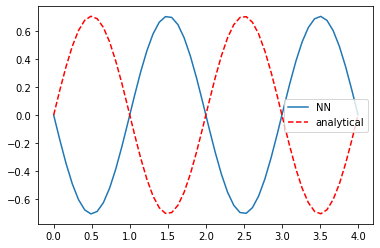

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
x = np.linspace(x0, x1)[:, None]
y = psi(params['nn'], x)

plt.plot(x, y, label='NN')  # Plotting the NN output
plt.plot(x, np.sqrt(2/L) * np.sin(n*np.pi * (x-x0)/L), 'r--', label='analytical')  # Plotting the actual wavefuncion
plt.legend()
plt.savefig (name + "_plot.png")

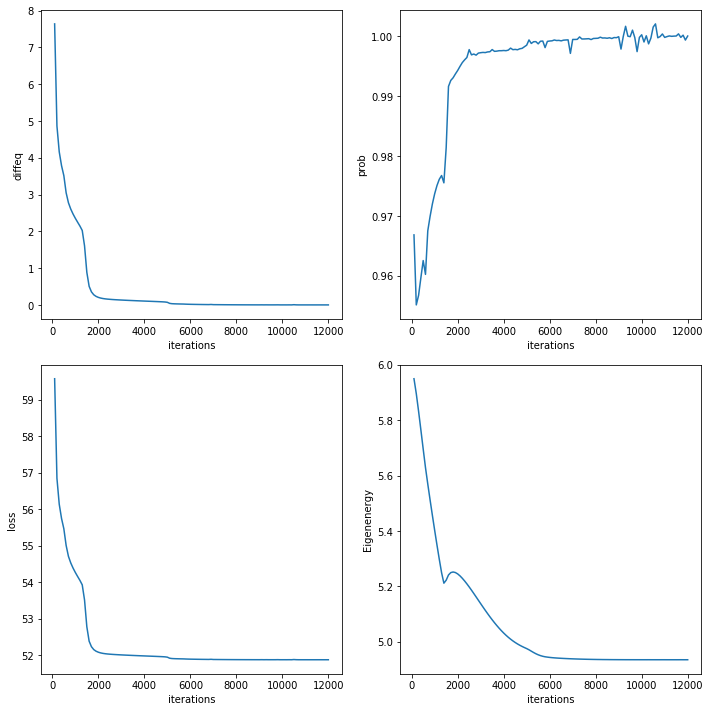

In [9]:
fig = plt.figure (figsize=(10,10))
plt.clf ()

plt.subplot (2 , 2 , 1)
plt.plot (iterList, diffeqList)
plt.xlabel ('iterations')
plt.ylabel ('diffeq')

plt.subplot (2, 2, 2)
plt.plot (iterList, probList)
plt.xlabel ('iterations')
plt.ylabel ('prob')

plt.subplot (2, 2, 3)
plt.plot (iterList, lossList)
plt.xlabel ('iterations')
plt.ylabel ('loss')

plt.subplot (2, 2, 4)
plt.plot (iterList, EList)
plt.ylabel ('Eigenenergy')
plt.xlabel ('iterations')
plt.tight_layout()

plt.savefig (name + "_diagAll.png")

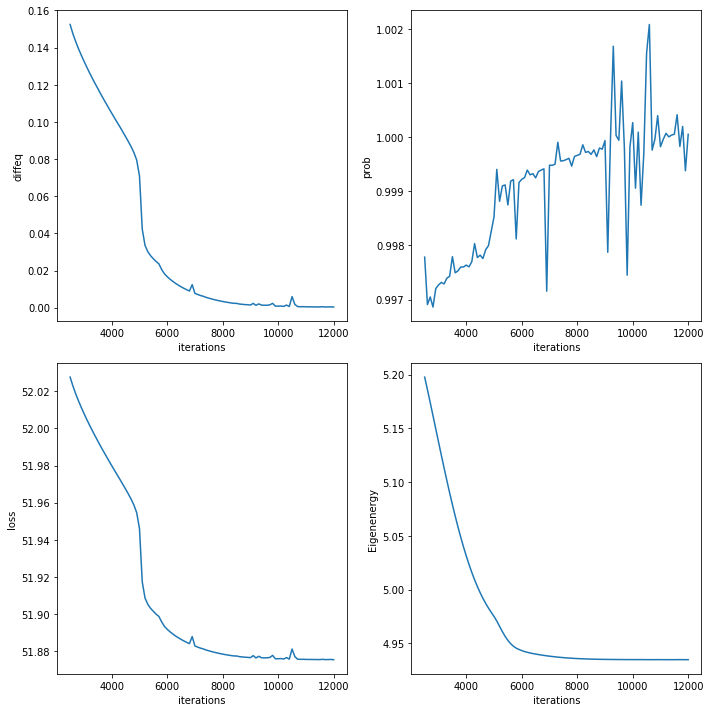

In [10]:
if trunc != -1 :
    fig = plt.figure (figsize=(10,10))

    plt.subplot (2 , 2 , 1)
    plt.plot (iterList[trunc:], diffeqList[trunc:])
    plt.xlabel ('iterations')
    plt.ylabel ('diffeq')

    plt.subplot (2, 2, 2)
    plt.plot (iterList[trunc:], probList[trunc:])
    plt.xlabel ('iterations')
    plt.ylabel ('prob')

    plt.subplot (2, 2, 3)
    plt.plot (iterList[trunc:], lossList[trunc:])
    plt.xlabel ('iterations')
    plt.ylabel ('loss')

    plt.subplot (2, 2, 4)
    plt.plot (iterList[trunc:], EList[trunc:])
    plt.ylabel ('Eigenenergy')
    plt.xlabel ('iterations')
    plt.tight_layout()

    plt.savefig (name + "_diagTrunc" + str(trunc) + ".png")

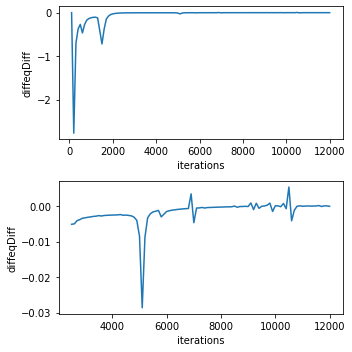

In [11]:
fig = plt.figure (figsize=(5,5))
plt.clf ()

if trunc != -1 :
    plt.subplot (2 , 1 , 1)
    plt.plot (iterList, diffeqDiffList)
    plt.xlabel ('iterations')
    plt.ylabel ('diffeqDiff')

    plt.subplot (2 , 1 , 2)
    plt.plot (iterList[trunc:], diffeqDiffList[trunc:])
    plt.xlabel ('iterations')
    plt.ylabel ('diffeqDiff')
else :
    plt.plot (iterList, diffeqDiffList)
    #plt.yticks ([min(diffeqDiffList), -10**-4, 10**-4, max(diffeqDiffList)])
    plt.xlabel ('iterations')
    plt.ylabel ('diffeqDiff')

plt.tight_layout()
plt.savefig (name + "_diffeqDiff.png")

# Write to file

In [12]:
outfile = open(name + "_info.txt" , "w")

fstr = "diffeq = " + str(round(diffeqList[-1],8)) + \
"\nprob = " + str(round(probList[-1],8)) + \
"\nloss = " + str(round(lossList[-1],8)) + \
"\neigE = " + str(round(EList[-1],8)) + \
"\ndiffeqDiff = " + str(round(diffeqDiffList[-1],8))

    
outfile.write (fstr)
outfile.close ()